<a href="https://colab.research.google.com/github/seimon-ohh/DHBW_WebDev_Opp_Zha/blob/main/snacktrack_tflite_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import json
import os
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from urllib.request import urlretrieve


In [21]:
with open('/content/export-2023-04-19T08_49_02.786Z (1).json', 'r') as file:
    data = json.load(file)


In [22]:
os.makedirs('images', exist_ok=True)

for entry in data:
    img_url = entry['Labeled Data']
    img_id = entry['ID']
    img_path = os.path.join('images', f'{img_id}.jpg')
    urlretrieve(img_url, img_path)


In [28]:
train_data = data[:int(len(data)*0.8)]
test_data = data[int(len(data)*0.8):]


In [29]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [30]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'],
              run_eagerly=True)


In [34]:
def data_generator(data_entries, batch_size=32):
    n = len(data_entries)
    if batch_size > n:
        batch_size = n

    while True:
        batch_entries = random.sample(data_entries, batch_size)

        batch_images = []
        batch_labels = []

        for entry in batch_entries:
            img_path = os.path.join('images', f"{entry['ID']}.jpg")
            img = image.load_img(img_path, target_size=(224, 224))
            img_array = image.img_to_array(img)
            img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

            batch_images.append(img_array)
            batch_labels.append(float(entry['Label']['objects'][0]['value'] == 'item'))

        print("Batch images:", len(batch_images), "Batch labels:", len(batch_labels))
        yield (tf.stack(batch_images), tf.convert_to_tensor(batch_labels, dtype=tf.float32))


In [37]:
train_generator = data_generator(train_data, batch_size=20)
steps_per_epoch = len(train_data) // 20
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=5)




Batch images: 20 Batch labels: 20
Epoch 1/5


/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Batch images: 20 Batch labels: 20


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/1 [==============================] - 6s 6s/step - loss: 0.9269 - accuracy: 0.2000
Epoch 2/5
Batch images: 20 Batch labels: 20
1/1 [==============================] - 6s 6s/step - loss: 0.7405 - accuracy: 0.4000
Epoch 3/5
Batch images: 20 Batch labels: 20
1/1 [==============================] - 5s 5s/step - loss: 0.5839 - accuracy: 0.7500
Epoch 4/5
Batch images: 20 Batch labels: 20
1/1 [==============================] - 5s 5s/step - loss: 0.4562 - accuracy: 0.9000
Epoch 5/5
Batch images: 20 Batch labels: 20
1/1 [==============================] - 5s 5s/step - loss: 0.3547 - accuracy: 0.9000


Non-Item gefunden (Wahrscheinlichkeit: 0.9279528856277466)


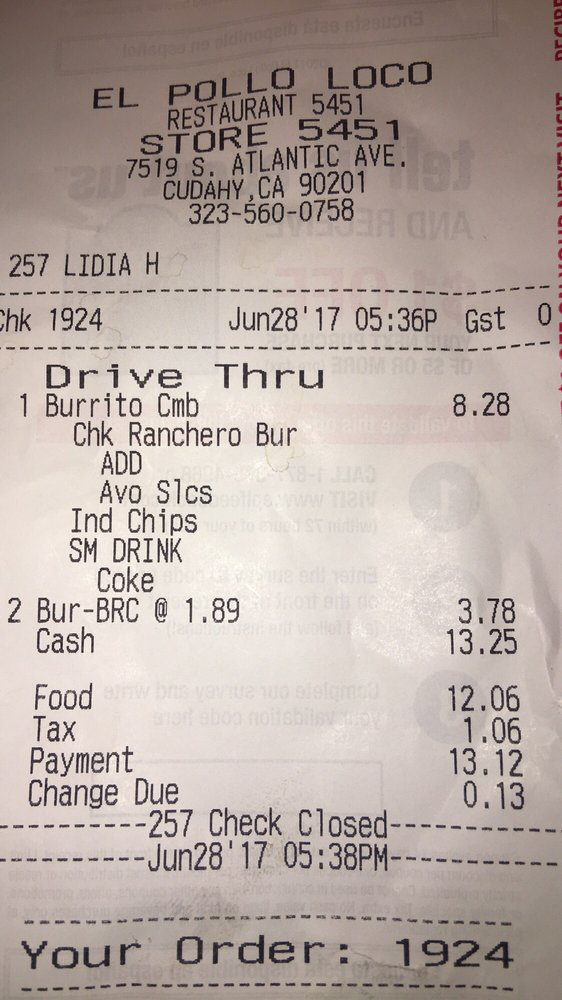

In [55]:
import random
from PIL import ImageDraw

# Zufälliges Bild aus dem Datensatz auswählen und analysieren
random_index = random.randint(0, len(train_data) - 1)
random_entry = train_data[random_index]

random_image_path = os.path.join('images', f"{random_entry['ID']}.jpg")
random_image = Image.open(random_image_path)
random_label = random_entry['Label']['objects']

# Bild verarbeiten
input_data = image.load_img(random_image_path, target_size=(224, 224))
img_array = image.img_to_array(input_data)
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
input_data = tf.expand_dims(img_array, axis=0)

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])

# Ergebnisse ausgeben
if output_data[0][0] > 0.5:  # Sie können den Schwellenwert anpassen
    print(f"Item gefunden (Wahrscheinlichkeit: {output_data[0][0]})")
    if 'bbox' in random_label[0]:
        bbox = random_label[0]['bbox']
        draw = ImageDraw.Draw(random_image)
        draw.rectangle([bbox['left'], bbox['top'], bbox['left'] + bbox['width'], bbox['top'] + bbox['height']], outline='red', width=3)
else:
    print(f"Non-Item gefunden (Wahrscheinlichkeit: {1 - output_data[0][0]})")

random_image.show()


In [ ]:
from google.colab import files

# Datei herunterladen
files.download('/content/my_model.pb')
